<a href="https://colab.research.google.com/github/bukhtiar-haider/opencv/blob/main/Green%20Screen%20Extraction%20Using%20OpenCV%20and%20Affine%20Transformations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib.request
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

In [2]:
url = "https://raw.githubusercontent.com/bukhtiar-haider/opencv/main/GreenScreen.jpg"
urllib.request.urlretrieve(url, "GreenScreen.jpg")

('GreenScreen.jpg', <http.client.HTTPMessage at 0x7f945039b490>)

In [3]:
# Loading the image
img = cv2.imread("GreenScreen.jpg", cv2.IMREAD_COLOR)

# Converting from RGB to HSV color space for color-based image segmentation
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# Define Upper and Lower HSV limits for the green screen
green_lower_bound = (45, 50, 50)
green_upper_bound = (70, 255, 255)

# Create a mask for green pixels
mask = cv2.inRange(hsv, green_lower_bound, green_upper_bound)

# Apply mask to the original image
masked_img = cv2.bitwise_and(img, img, mask=mask)

# Apply Gaussian Blur
kernel_size = (3, 3)
sigma = 2
img_blur = cv2.GaussianBlur(mask, kernel_size, sigma)

# Extract contours from the subtracted image
contours, tree = cv2.findContours(img_blur, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Smooth the contours using approxPolyDP to get a Rhombus
epsilon = 20
approx_contours = []
for c in contours:
    approx = cv2.approxPolyDP(c, epsilon, True)
    approx_contours.append(approx)

# Get the largest contour from the set of extracted contours
largest_contour = max(approx_contours, key=cv2.contourArea)

# Get transformation source points from the rectangle vertices
unordered_corners = largest_contour.astype(np.float32)
top_left = unordered_corners[0][0]
top_right = unordered_corners[3][0]
bottom_right = unordered_corners[2][0]
bottom_left = unordered_corners[1][0]
source_pixels = np.array((top_left, top_right, bottom_right, bottom_left))

# Get transformation destination points (original image corners)
width, height = img.shape[:2]
dest_pixels = np.array([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]], dtype=np.float32)

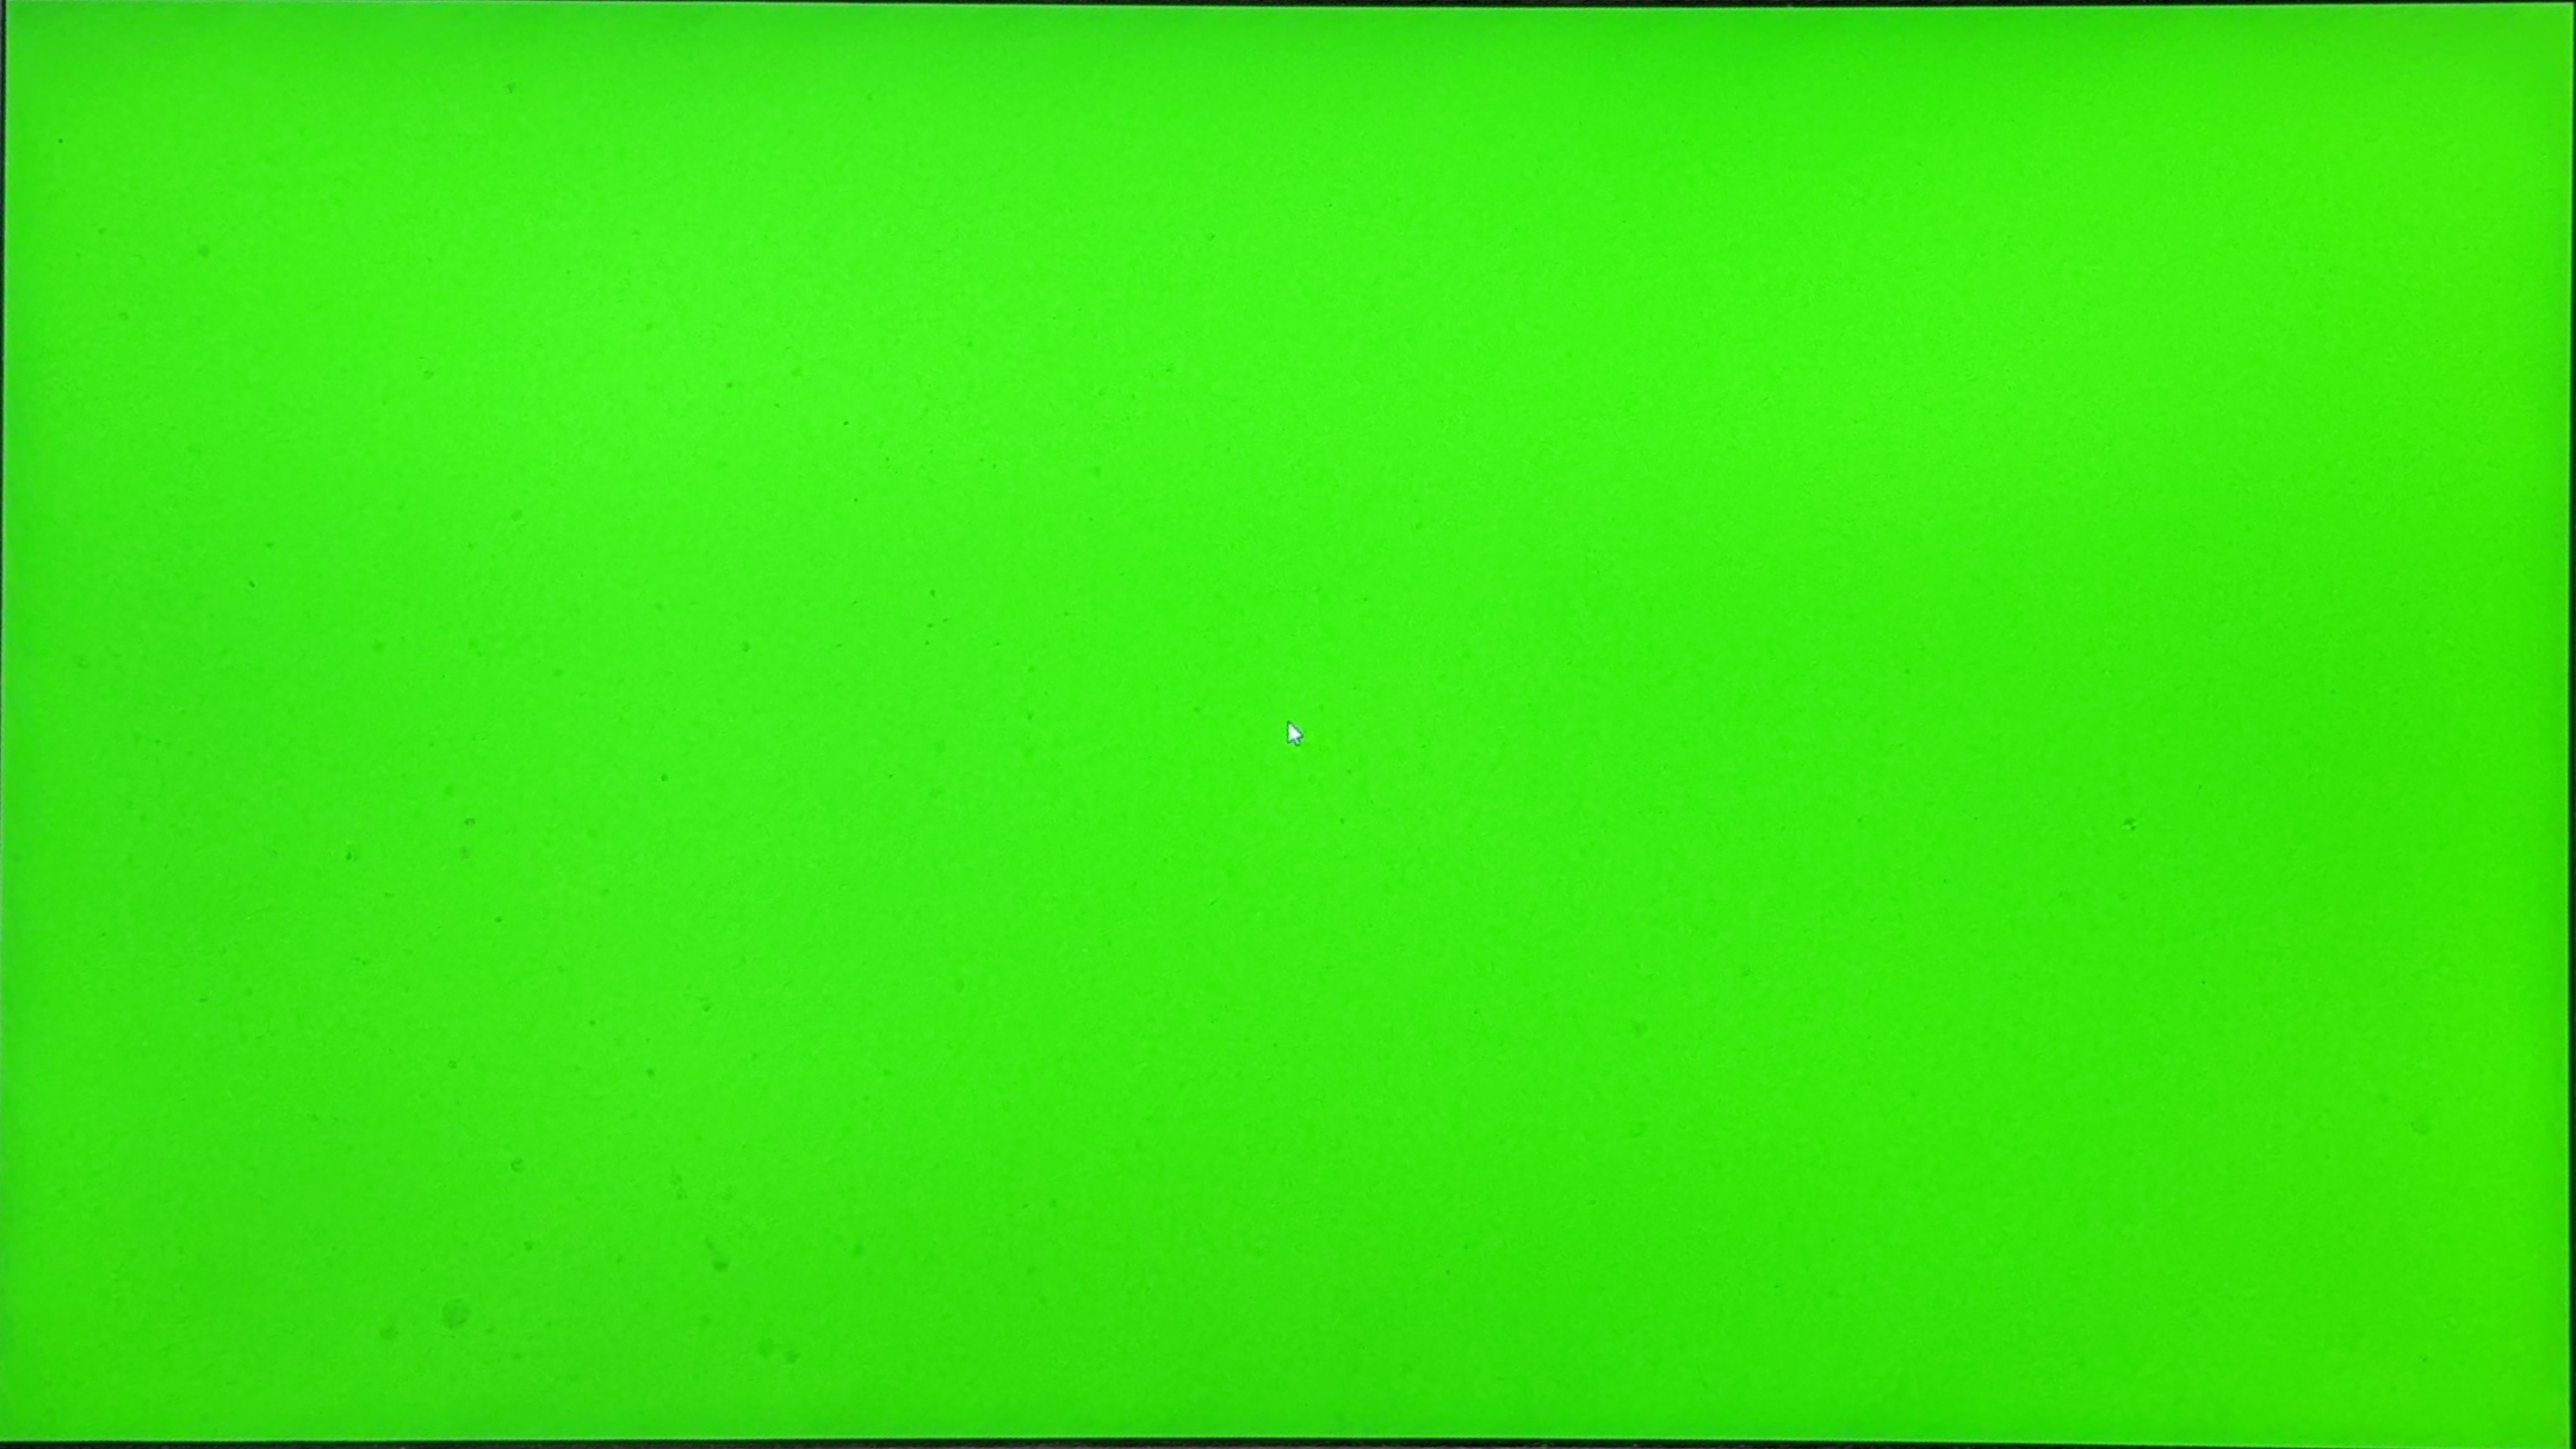

In [4]:
# Calculate & apply the affine transformation
M = cv2.getPerspectiveTransform(source_pixels, dest_pixels)
transformed_img = cv2.warpPerspective(img, M, (width, height))

# Realign the aspect ratio of the transformed image to 16:9
new_width = int(height * 16 / 9)
new_height = height

# Resize the image to the new dimensions using bilinear interpolation
resized = cv2.resize(transformed_img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

# Display the resized image
cv2_imshow(resized)
# cv2.waitKey(0)
# cv2.destroyAllWindows()